<a href="https://colab.research.google.com/github/lauraAriasFdez/TensorFlowSpecialization/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***TRANSFER LEARNING***

For more on how to freeze/lock layers, explore the documentation, which includes an example using MobileNet architecture: https://www.tensorflow.org/tutorials/images/transfer_learning



## 1. DOWNLOAD Pretrain Model

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model


## This is a snapshot of the model after being trained
# It is a copy of the pretrained weights for the inception NN 
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  


--2021-11-30 16:24:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   189MB/s    in 0.4s    

2021-11-30 16:24:04 (189 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:

# 1. Download the base model (pretrained)_________________-
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


# Instantiate the pretrained model with the input shape of YOUR data and
# specify you do NOT want to use built-in weights 
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(local_weights_file)


#2. Interate through its layers and lock them = saying NOT trainable______
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()


# 3- Find the layer in which the convolution output is 7 by 7 instead of 3 by 3
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## 2. Add Trainable Layers to the Model

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [4]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:01<00:00, 61.5MB/s]
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 37s - loss: 0.3414 - accuracy: 0.8685 - val_loss: 0.1404 - val_accuracy: 0.9410 - 37s/epoch - 372ms/step
Epoch 2/20
100/100 - 22s - loss: 0.1985 - accuracy: 0.9245 - val_loss: 0.1036 - val_accuracy: 0.9630 - 22s/epoch - 225ms/step
Epoch 3/20
100/100 - 23s - loss: 0.2233 - accuracy: 0.9145 - val_loss: 0.1928 - val_accuracy: 0.9380 - 23s/epoch - 232ms/step
Epoch 4/20
100/100 - 22s - loss: 0.1979 - accuracy: 0.9350 - val_loss: 0.1115 - val_accuracy: 0.9610 - 22s/epoch - 223ms/step
Epoch 5/20
100/100 - 23s - loss: 0.1638 - accuracy: 0.9390 - val_loss: 0.1851 - val_accuracy: 0.9400 - 23s/epoch - 231ms/step
Epoch 6/20
100/100 - 22s - loss: 0.1828 - accuracy: 0.9320 - val_loss: 0.1554 - val_accuracy: 0.9500 - 22s/epoch - 224ms/step
Epoch 7/20
100/100 - 23s - loss: 0.1803 - accuracy: 0.9430 - val_loss: 0.0979 - val_accuracy: 0.9690 - 23s/epoch - 228ms/step
Epoch 8/20
100/100 - 22s - loss: 0.1527 - accuracy: 0.9450 - val_loss: 0.0928 - val_accuracy: 0.9700 - 22s/epoch - 221

## 3. Plot the training accuarcy 

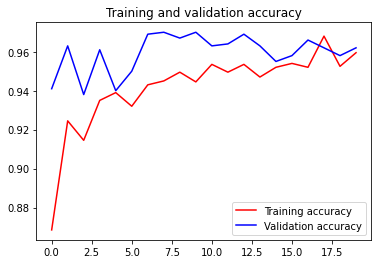

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# DROPOUT


remove a random number of neurons in your neural network.

1. Neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this.

2. Often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit! 


https://www.youtube.com/watch?v=ARq74QuavAo



Set dropout of 20% of nodes

```
x = layers.Dropout(0.2)(x)
```


***If Dropout rate Too High*** = The network would lose specialization to the effect that it would be inefficient or ineffective at learning, driving accuracy down


